In [1]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage, RemoveMessage, AnyMessage
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing import Dict, List, TypedDict

from IPython.display import Image, display

from langchain_openai import ChatOpenAI

In [2]:
def filter_out_messages(messages: List[AnyMessage]) -> List[AnyMessage]:
    return [m for m in messages if not (isinstance(m, ToolMessage) or (hasattr(m, "tool_calls") and len(m.tool_calls) > 0) or isinstance(m, SystemMessage))]

In [3]:
# Esquema para el calculador

class CalculatorSchema(MessagesState):
    execution_environment: Dict # Este debería estar solo en el agente con tools (assistant)

# class CalculatorSchema(TypedDict):
#     calc_messages: List[AnyMessage] # Este tiene que llamarse de otra manera porque es de distinto tipo que el messages de MessagesState
#     execution_environment: Dict # Este debería estar solo en el agente con tools (assistant)
#     # summary: str
    
# Esquema para el summarizer
class SummarizerSchema(MessagesState):
    # execution_environment: Dict # Este no tendría que estar aquí
    summary: str # Este es solo para el summarizer

llm = ChatOpenAI(model="gpt-4o")

def summarizer(state: SummarizerSchema):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = filter_out_messages(state["messages"]) + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2] if not (isinstance(m, ToolMessage) or hasattr(m, "tool_calls"))]
    return {"summary": response.content, "messages": delete_messages}

def should_tools_or_summarize(state: CalculatorSchema):

    messages = state['messages']
    message = messages[-1]
    
    # It it is a tool call, we should go to the tool
    if hasattr(message, "tool_calls") and len(message.tool_calls) > 0:
        return "tools"
    
    if len(filter_out_messages(messages)) > 10:
        print("Summarizing ({})".format(len(messages)))
        return "summarizer"
    else:
        print("Not summarizing ({})".format(len(messages)))
        return END

In [4]:
# from langchain_openai import ChatOpenAI

from arithmetics import add, subtract, multiply, divide, power, run_code, get_calculator_locals, get_calculator_globals, get_calculator_all, codeExecutor

tools = [add, subtract, multiply, divide, power, run_code, get_calculator_locals, get_calculator_globals, get_calculator_all]

# llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_message = """
"You are a helpful assistant tasked with performing arithmetic operations. 
You can use the following operations: addition, subtraction, multiplication, division, and power. 

You can also run tour own code. You can do so by:

1 - Using 'run_code' 
2 - Then use `print_var` the times you need to get the variable(s) of your interest in order to fulfill the task or the user's request.


As far as now, these are the local variables you can access:

{locals}

And these are the global variables you can access:

{globals}
"""

2025-02-18 20:15:29 [INFO] [tracer:<module>] - El nivel de log actual es: DEBUG


In [5]:
def assistant(state: CalculatorSchema):
    
    # sys_msg = SystemMessage(content=sys_message.format(locals = codeExecutor.get_locals(), globals = codeExecutor.get_globals()))
    str_sys_msg = sys_message.format(locals = codeExecutor.get_locals(), globals = codeExecutor.get_globals())
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        str_sys_msg = str_sys_msg + f"\n\nSummary of conversation earlier: {summary}"
        
    messages = [SystemMessage(content=str_sys_msg)] + state["messages"]
    
    out = {
        "messages": [llm_with_tools.invoke(messages)],
        "execution_environment": get_calculator_all(),
        }
    
    return out


In [6]:
# Graph
builder_calc = StateGraph(CalculatorSchema)

builder_calc.add_node("assistant", assistant)
builder_calc.add_node("tools", ToolNode(tools))
builder_calc.add_node("summarizer", summarizer)

builder_calc.add_edge(START, "assistant")
builder_calc.add_conditional_edges(
    "assistant",
    should_tools_or_summarize,
)
builder_calc.add_edge("tools", "assistant")
builder_calc.add_edge("summarizer", END)

memory = MemorySaver()

calculator_agent = builder_calc.compile(checkpointer=memory)

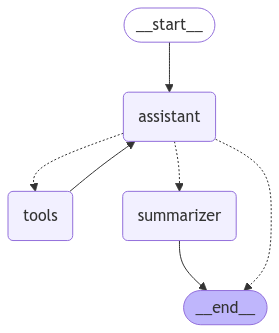

In [7]:
display(Image(calculator_agent.get_graph(xray=1).draw_mermaid_png()))

In [8]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

In [9]:
# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

Python REPL can execute arbitrary code. Use with caution.


Not summarizing (4)
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [10]:
calculator_agent.get_state(config).values

{'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='33b98a8b-7753-4a24-b79d-ef7324904901'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XSn5hbaAbo74Q117fPKmgLOD', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 766, 'total_tokens': 784, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5d059858-f690-4758-8a84-5f4f5c300a6a-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_XSn5hbaAbo74Q117fPKmgLOD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 766, 'output_tokens': 18, 'total_t

In [11]:
input_message = HumanMessage(content="Multiply that by 2")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

========

In [12]:
input_message = HumanMessage(content="Add 5 and 6, divide the reesult by 3 and raise it to the power of 2")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ATOGJucJPXSOmbuv7eWi93Kg)
 Call ID: call_ATOGJucJPXSOmbuv7eWi93Kg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result

In [13]:
input_message = HumanMessage(content="Tell me about your capacities")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ATOGJucJPXSOmbuv7eWi93Kg)
 Call ID: call_ATOGJucJPXSOmbuv7eWi93Kg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result

In [14]:
input_message = HumanMessage(content="What's in your execution environment?")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ATOGJucJPXSOmbuv7eWi93Kg)
 Call ID: call_ATOGJucJPXSOmbuv7eWi93Kg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result

In [15]:
input_message = HumanMessage(content="build a random 1000 x 3 dataframe and show it to me")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ATOGJucJPXSOmbuv7eWi93Kg)
 Call ID: call_ATOGJucJPXSOmbuv7eWi93Kg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result

In [16]:
input_message = HumanMessage(content="Now, what's in your execution environment?")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ATOGJucJPXSOmbuv7eWi93Kg)
 Call ID: call_ATOGJucJPXSOmbuv7eWi93Kg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_Q1QOLs2Yu4oMZZL1jECHT2EI)
 Call ID: call_Q1QOLs2Yu4oMZZL1jECH

In [17]:
input_message = HumanMessage(content="Tell me: what have we being talking about till now?")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (call_XSn5hbaAbo74Q117fPKmgLOD)
 Call ID: call_XSn5hbaAbo74Q117fPKmgLOD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ATOGJucJPXSOmbuv7eWi93Kg)
 Call ID: call_ATOGJucJPXSOmbuv7eWi93Kg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_Q1QOLs2Yu4oMZZL1jECHT2EI)
 Call ID: call_Q1QOLs2Yu4oMZZL1jECH

In [19]:
input_message = HumanMessage(content="Provide a summary of our conversation till now")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LEpmEdJDLU0J5YQ3tOvlRYIa)
 Call ID: call_LEpmEdJDLU0J5YQ3tOvlRYIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_FTHcLSAvOagiNTG976AO2rFJ)
 Call ID: call_FTHcLSAvOagiNTG976AO2rFJ
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11

================================== Ai Message ==================================
Tool Calls:
  divide (call_PAZFsbqjkbDogE6HgkHXycOt)
 Call ID: call_PAZFsbqjkbDogE6H

In [20]:
# Specify an input
messages = [HumanMessage(content="What functions you have as tools?")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

Summarizing (28)
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LEpmEdJDLU0J5YQ3tOvlRYIa)
 Call ID: call_LEpmEdJDLU0J5YQ3tOvlRYIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_FTHcLSAvOagiNTG976AO2rFJ)
 Call ID: call_FTHcLSAvOagiNTG976AO2rFJ
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11

================================== Ai Message ==================================
Tool Calls:
  divide (call_PAZFsbqjkbDogE6HgkHXycOt)
 Call ID: call

In [21]:
# Specify an input
messages = [HumanMessage(content="What dou you think you're good at?")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

Summarizing (29)
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LEpmEdJDLU0J5YQ3tOvlRYIa)
 Call ID: call_LEpmEdJDLU0J5YQ3tOvlRYIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_FTHcLSAvOagiNTG976AO2rFJ)
 Call ID: call_FTHcLSAvOagiNTG976AO2rFJ
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11

================================== Ai Message ==================================
Tool Calls:
  divide (call_PAZFsbqjkbDogE6HgkHXycOt)
 Call ID: call

In [22]:
# Specify an input
messages = [HumanMessage(content="What tools would you like to add to yours?")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

Summarizing (30)
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LEpmEdJDLU0J5YQ3tOvlRYIa)
 Call ID: call_LEpmEdJDLU0J5YQ3tOvlRYIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_FTHcLSAvOagiNTG976AO2rFJ)
 Call ID: call_FTHcLSAvOagiNTG976AO2rFJ
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11

================================== Ai Message ==================================
Tool Calls:
  divide (call_PAZFsbqjkbDogE6HgkHXycOt)
 Call ID: call

In [23]:
calculator_agent.get_state(config).values

{'messages': [AIMessage(content='The result of adding 3 and 4 is 7.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 766, 'total_tokens': 781, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-5214bef8-455d-4e0e-9f8d-8af569885356-0', usage_metadata={'input_tokens': 766, 'output_tokens': 15, 'total_tokens': 781, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LEpmEdJDLU0J5YQ3tOvlRYIa', 'function': {'arguments': '{"a":7,"b":2}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_

In [24]:
all_states = [s for s in calculator_agent.get_state_history(config)]

In [25]:
len(all_states)

62

In [28]:
for s in range(len(all_states)):
    # print(f"\n\n{s}\n\n{[value for value in all_states[s].values['messages']]}")
    print(f"\n\n{s}\n\n")
    for value in all_states[s].values['messages']:
        value.pretty_print()



0


================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LEpmEdJDLU0J5YQ3tOvlRYIa)
 Call ID: call_LEpmEdJDLU0J5YQ3tOvlRYIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_FTHcLSAvOagiNTG976AO2rFJ)
 Call ID: call_FTHcLSAvOagiNTG976AO2rFJ
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11

================================== Ai Message ==================================
Tool Calls:
  divide (call_PAZFsbqjkbDogE6HgkHXycOt)
 Call ID: call_PAZFsbqjkb

In [27]:
print(all_states[45].values['messages'])

[HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='4281d5cf-87c5-454b-8492-fb69d411d9a0'), AIMessage(content='The result of adding 3 and 4 is 7.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 766, 'total_tokens': 781, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-5214bef8-455d-4e0e-9f8d-8af569885356-0', usage_metadata={'input_tokens': 766, 'output_tokens': 15, 'total_tokens': 781, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Multiply that by 2', additional_kwargs={}, response_metadata={}, id='33afdf1c-a2e5-44b1-9baa-b

In [32]:
calculator_agent.checkpointer.get(config).keys()

dict_keys(['v', 'ts', 'id', 'channel_values', 'channel_versions', 'versions_seen', 'pending_sends'])

In [34]:
calculator_agent.checkpointer.get(config)['channel_values'].keys()

dict_keys(['messages', 'execution_environment', 'summary', 'summarizer'])

In [35]:
calculator_agent.checkpointer.get(config)['channel_versions'].keys()

dict_keys(['__start__', 'messages', 'start:assistant', 'execution_environment', 'assistant', 'branch:assistant:should_tools_or_summarize:tools', 'tools', 'branch:assistant:should_tools_or_summarize:summarizer', 'summary', 'summarizer'])

In [36]:
calculator_agent.checkpointer.get(config)['versions_seen'].keys()

dict_keys(['__input__', '__start__', 'assistant', 'tools', 'summarizer'])

In [38]:
calculator_agent.checkpointer.get(config)['pending_sends']

[]

In [44]:
for m in (calculator_agent.checkpointer.get(config)['channel_values']['messages']):
    m.pretty_print()

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LEpmEdJDLU0J5YQ3tOvlRYIa)
 Call ID: call_LEpmEdJDLU0J5YQ3tOvlRYIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14

================================== Ai Message ==================================

The result of multiplying 7 by 2 is 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_FTHcLSAvOagiNTG976AO2rFJ)
 Call ID: call_FTHcLSAvOagiNTG976AO2rFJ
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11

================================== Ai Message ==================================
Tool Calls:
  divide (call_PAZFsbqjkbDogE6HgkHXycOt)
 Call ID: call_PAZFsbqjkbDogE6H

In [47]:
for ee in calculator_agent.checkpointer.get(config)['channel_values']['execution_environment']:
    print(ee)

{'result': '13.444444444444443\n', 'pd': "<module 'pandas' from '/home/miguel-conde/Documents/tst_ai_ds_team/.venv/lib/python3.12/site-packages/pandas/__init__.py'>\n", 'np': "<module 'numpy' from '/home/miguel-conde/Documents/tst_ai_ds_team/.venv/lib/python3.12/site-packages/numpy/__init__.py'>\n", 'df': '            A         B         C\n0    0.049668  0.957387  0.848738\n1    0.292520  0.109941  0.306126\n2    0.401599  0.804853  0.613408\n3    0.383382  0.874731  0.616196\n4    0.472061  0.814923  0.611118\n..        ...       ...       ...\n995  0.893245  0.070514  0.772323\n996  0.467790  0.170705  0.840353\n997  0.970176  0.373754  0.638288\n998  0.678083  0.245379  0.682520\n999  0.380576  0.216310  0.353867\n\n[1000 rows x 3 columns]\n'}
{}


In [50]:
print(calculator_agent.checkpointer.get(config)['channel_values']['summary'])

### Enhanced Feature Suggestions:
In the latter part of the interaction, the conversation shifted towards potential enhancements to the assistant's existing capabilities. A thoughtful discussion emerged around tools that could augment functionality, spanning advanced data analysis, visualization, and machine learning interfacing.

1. **Advanced Statistical and Analytical Tools**: The addition of complex statistical functions would allow for deeper data analysis, providing insights through calculations like standard deviation and regression.

2. **Data Visualization Capabilities**: Integrating libraries like Matplotlib or Seaborn for creating visual data representations would empower users to more effectively interpret and communicate findings from data analyses.

3. **Matrix and String Operations**: Enhancements in matrix operations and advanced string manipulation could broaden the assistant's utility in scientific and technical domains, enabling more sophisticated data processing tec